In [7]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import os
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense

### Loading data

In [2]:
# Assuming 'monks1_train_path' is the path to your data file
monks1_train_path = os.getcwd() + '/../../data/monks/monks-1.train'

# Specify the column names or let pandas infer them
column_names = ['target', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'id']

# Load the data into a pandas DataFrame
df = pd.read_csv(monks1_train_path, names=column_names, delimiter=' ')

# Display the loaded data
df

,target,col1,col2,col3,col4,col5,col6,id
NaN,1,1,1,1,1,3,1,data_5
NaN,1,1,1,1,1,3,2,data_6
NaN,1,1,1,1,3,2,1,data_19
NaN,1,1,1,1,3,3,2,data_22
NaN,1,1,1,2,1,2,1,data_27
...,...,...,...,...,...,...,...,...
NaN,1,3,3,2,1,4,2,data_416
NaN,1,3,3,2,3,1,2,data_426
NaN,1,3,3,2,3,2,2,data_428
NaN,1,3,3,2,3,3,2,data_430


In [3]:
labels = df["target"].values.astype(float)


NameError: name 'y' is not defined

In [4]:
# Assuming your DataFrame has features and labels columns
# Replace 'features' and 'labels' with your actual column names
X = df[['col1', 'col2', 'col3', 'col4', 'col5', 'col6']].values
y = df[['target']].values

Epoch 1/110
4/4 [==============================] - 1s 85ms/step - loss: 0.8017 - accuracy: 0.4141 - val_loss: 0.6821 - val_accuracy: 0.5200
Epoch 2/110
4/4 [==============================] - 0s 22ms/step - loss: 0.7248 - accuracy: 0.4444 - val_loss: 0.8018 - val_accuracy: 0.2400
Epoch 3/110
4/4 [==============================] - 0s 21ms/step - loss: 0.6808 - accuracy: 0.6162 - val_loss: 0.8990 - val_accuracy: 0.2000
Epoch 4/110
4/4 [==============================] - 0s 16ms/step - loss: 0.6668 - accuracy: 0.5657 - val_loss: 0.9934 - val_accuracy: 0.1600
Epoch 5/110
4/4 [==============================] - 0s 18ms/step - loss: 0.6565 - accuracy: 0.6061 - val_loss: 1.0315 - val_accuracy: 0.1600
Epoch 6/110
4/4 [==============================] - 0s 17ms/step - loss: 0.6500 - accuracy: 0.6061 - val_loss: 1.0316 - val_accuracy: 0.1600
Epoch 7/110
4/4 [==============================] - 0s 21ms/step - loss: 0.6450 - accuracy: 0.6061 - val_loss: 1.0318 - val_accuracy: 0.1600
Epoch 8/110
4/4 [===

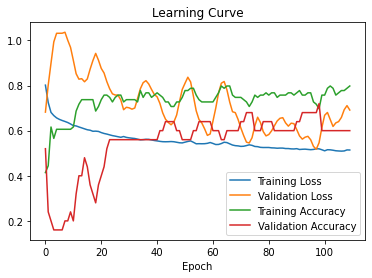

In [14]:
# Define a simple neural network with Keras
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X.shape[1]))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model and obtain the training history
history = model.fit(X, y, epochs=110, batch_size=32, validation_split=0.2)

# Plot the learning curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.legend()